In [10]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [11]:
def mag_and_angle_to_cmplx(mag, angle):
    # Convert magnitude and angle to a complex number as a + bj
    return mag * np.exp(1j * angle)

In [12]:
# Define the parameters of the system
fn = 60

H_gen = 3.5
X_gen = 0.2
X_ibb = 0.1
X_line = 0.65

# Define the initial values of the system.
# (Values are initialized from loadflow which is not shown here)
E_fd_gen = 1.075
E_fd_ibb = 1.033
P_m_gen = 1998/2200

omega_gen_init = 0
delta_gen_init = np.deg2rad(45.9)
delta_ibb_init = np.deg2rad(-5.0)

v_bb_gen_init = mag_and_angle_to_cmplx(1.0, np.deg2rad(36.172))

In [13]:
def differential(omega, v_bb_gen, delta):
    # Calculate the electrical power extracted from the generator at its busbar.
    E_gen_cmplx = mag_and_angle_to_cmplx(E_fd_gen, delta)
    P_e_gen = (v_bb_gen * np.conj((E_gen_cmplx - v_bb_gen) / (1j * X_gen))).real

    # transform the constant mechanical energy into torque
    T_m_gen = P_m_gen / (1 + omega)

    # Differential equations of a generator according to Machowski
    domega_dt = 1 / (2 * H_gen) * (T_m_gen - P_e_gen)
    ddelta_dt = omega * 2 * np.pi * fn

    return domega_dt, ddelta_dt


def algebraic(delta_gen, sc_on):
    # If the SC is on, the admittance matrix is different.
    # The SC on busbar 0 is expressed in the admittance matrix as a very large admittance (1000000) i.e. a very small impedance.
    if sc_on:
        y_adm = np.array([[(-1j / X_gen - 1j / X_line) + 1000000, 1j / X_line],
                          [1j / X_line, -1j / X_line - 1j / X_ibb]])
    else:
        y_adm = np.array([[-1j / X_gen - 1j / X_line, 1j / X_line],
                          [1j / X_line, -1j / X_line - 1j / X_ibb]])

    # Calculate the inverse of the admittance matrix (Y^-1)
    y_inv = np.linalg.inv(y_adm)

    # Calculate current injections of the generator and the infinite busbar
    i_inj_gen = mag_and_angle_to_cmplx(E_fd_gen, delta_gen) / (1j * X_gen)
    i_inj_ibb = mag_and_angle_to_cmplx(E_fd_ibb, delta_ibb_init) / (1j * X_ibb)

    # Calculate voltages at the bus by multiplying the inverse of the admittance matrix with the current injections
    v_bb_gen = y_inv[0, 0] * i_inj_gen + y_inv[0, 1] * i_inj_ibb
    v_bb_ibb = y_inv[1, 0] * i_inj_gen + y_inv[1, 1] * i_inj_ibb

    return v_bb_gen

In [14]:
def do_sim():

    # Initialize the variables
    omega_gen = omega_gen_init
    delta_gen = delta_gen_init
    v_bb_gen = v_bb_gen_init

    # Define time. Here, the time step is 0.005 s and the simulation is 5 s long
    t = np.arange(0, 5, 0.005)
    x_result = []

    for timestep in t:

        # Those lines cause a short circuit at t = 1 s until t = 1.05 s
        if 1 <= timestep <= 1.05:
            sc_on = True
        else:
            sc_on = False

        # Calculate the differences to the next step by executing the differential equations at the current step
        domega_dt, ddelta_dt = differential(omega_gen, v_bb_gen, delta_gen)
        omega_gen = omega_gen + domega_dt * (t[1] - t[0])
        delta_gen = delta_gen + ddelta_dt * (t[1] - t[0])

        v_bb_gen = algebraic(delta_gen, sc_on)

        # Save the results, so they can be plotted later
        x_result.append(omega_gen)

    # Convert the results to a numpy array
    res = np.vstack(x_result)
    return t, res

Text(0.5, 1.0, 'Reaction of a generator to a short circuit')

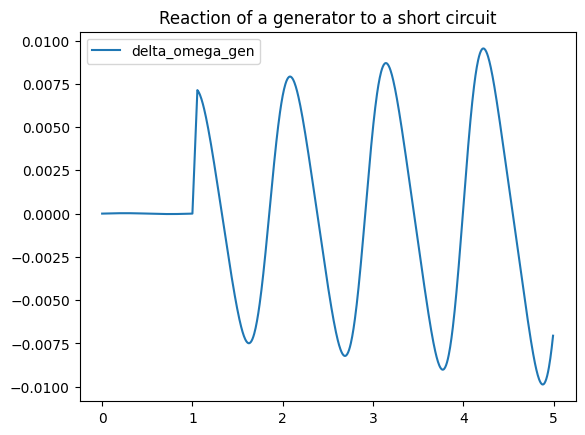

In [15]:
# Here the simulation is executed and the timesteps and corresponding results are returned.
# In this example, the results are omega, delta, e_q_t, e_d_t, e_q_st, e_d_st of the generator and the IBB
t_sim, res = do_sim()

# Plot the results
plt.plot(t_sim, res[:, 0].real, label='delta_omega_gen')
plt.legend()
plt.title('Reaction of a generator to a short circuit')